In [2]:
import h5py as h5
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    validation_curve,
)
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

In [3]:
np.random.seed(42)

In [4]:
# Grab extracted features and labels (TRAIN SET).
with h5.File('features_train.h5', 'r') as file:
    X_train, y_train = file['images'][:], file['labels'][:]
    classes = file['classes'][:]

### SVM Classification

In [6]:
# Params used to find the best estimator.
params = {
    'C': [0.001, 0.01, 0.01, 1.0, 10.0, 100.0],
    'degree': [1, 2, 3, 4],
    'kernel': ['poly', 'rbf'],
    'coef0': [0, 1.0, 2.0]
}

model = GridSearchCV(
    SVC(),
    param_grid=params,
    cv=3,
    n_jobs=-1, # -1: all cores
    verbose=2,
)

In [7]:
model.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 18.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.01, 1.0, 10.0, 100.0],
                         'coef0': [0, 1.0, 2.0], 'degree': [1, 2, 3, 4],
                         'kernel': ['poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [8]:
print('Best estimator is', model.best_estimator_)
print('Best score is', model.best_score_)

Best estimator is SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=1.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best score is 0.9216867469879518


### Train the best model

In [9]:
best_model = model.best_estimator_

best_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=1.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Cross-Validation Score

In [10]:
cvscore = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

In [11]:
f'Cross Validation Score is ~{round(np.average(cvscore), 3) * 100}%.'

'Cross Validation Score is ~91.8%.'

### Confusion matrix

In [12]:
y_train_preds = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
)

In [13]:
confusion_matrix(y_train, y_train_preds)

array([[221,  28],
       [ 13, 236]])

### Precision

In [14]:
precision_score(y_train, y_train_preds)

0.8939393939393939

### Recall

In [15]:
recall_score(y_train, y_train_preds)

0.9477911646586346

### F1-Score (harmonic mean)

In [16]:
f1_score(y_train, y_train_preds)

0.9200779727095517

### Precision recall curve

In [17]:
y_scores = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=5,
    method='decision_function',
    n_jobs=-1,
)

In [18]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

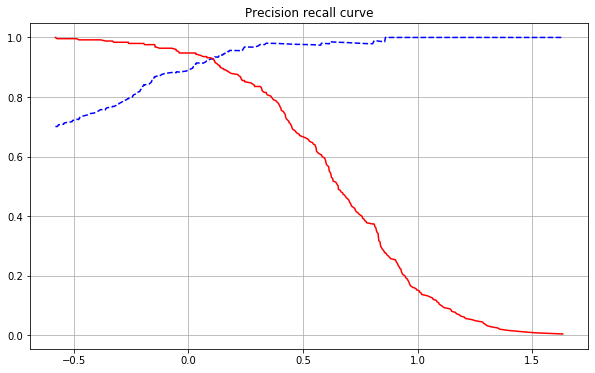

In [19]:
plt.figure(figsize=(10, 6))
plt.title('Precision recall curve')
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
plt.grid()
plt.show()

### ROC Curve

In [20]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

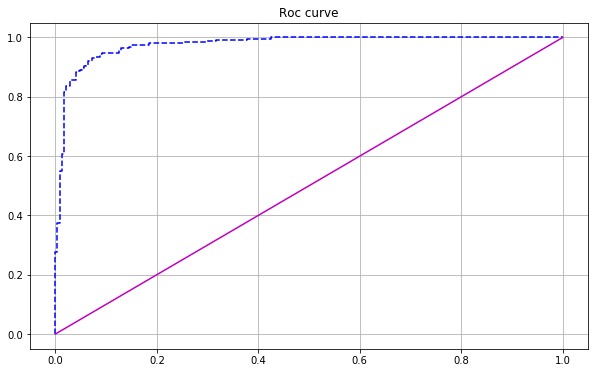

In [21]:
plt.figure(figsize=(10, 6))
plt.title('Roc curve')
plt.plot(fpr, tpr, 'b--')
plt.plot([0, 1], [0, 1], 'm-')
plt.grid()
plt.show()

### ROC-AUC Score

In [22]:
roc_auc_score(y_train, y_scores)

0.9764842502540283

### Learning curve

In [23]:
lrn_curve = learning_curve(
    best_model,
    X_train,
    y_train,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
)

In [24]:
train_sizes_abs, train_scores, val_scores = lrn_curve

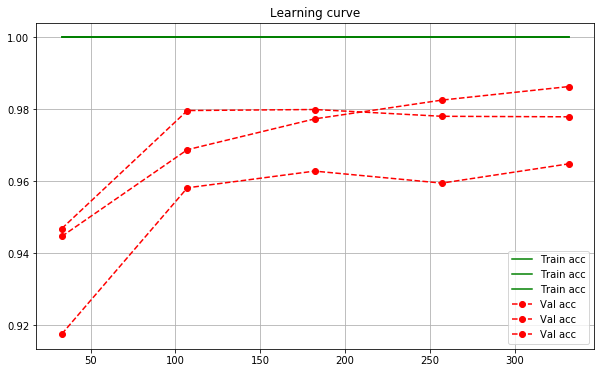

In [25]:
plt.figure(figsize=(10, 6))
plt.title('Learning curve')
plt.plot(train_sizes_abs, train_scores, 'g-', label='Train acc')
plt.plot(train_sizes_abs, val_scores, 'ro--', label='Val acc')
plt.legend(loc='best')
plt.grid()
plt.show()